In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys


c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# read in the data
accidents_data = pd.read_csv('processed_us_car_accidents_2022.csv')

# show columns
print(accidents_data.columns)

Index(['Unnamed: 0', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lattitude', 'Start_Longitude', 'End_Lattitude', 'End_Longitude',
       'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Traffic_Signal', 'Sunrise_Sunset', 'State_Abbrv',
       'Population'],
      dtype='object')


In [3]:
# fisrt filter out the data in South Carolina
accidents_data = accidents_data[accidents_data['State'] == 'SC']

To automate the task of determining whether an accident occurred on a highway and its orientation (North, South, East, West), we can write a Python script that processes the descriptions. The script will use regular expressions to search for keywords indicating highway involvement and direction. If a highway is mentioned with a direction, it will return the respective orientation. If no highway or direction is indicated, it will return "Not_Highway".

In [4]:
def analyze_description(description):
    # Regular expressions to find highway and direction mentions
    highway_pattern = re.compile(r'\b(I-\d+|US-\d+|[A-Z]{2}-\d+)\b', re.IGNORECASE)
    direction_pattern = re.compile(r'\b(Northbound|Southbound|Eastbound|Westbound|NB|SB|EB|WB|North|South|East|West|N|S|E|W)\b', re.IGNORECASE)

    # capitalize the description
    description = description.upper()

    # Search for patterns in the description
    highway_match = highway_pattern.search(description)
    direction_match = direction_pattern.search(description)

    # Determine if the incident is on a highway and its orientation
    if highway_match:
        if direction_match:
            # Extract the first word of the direction match as the orientation
            direction = direction_match.group(0).split()[0]
            return direction[0]  # Return only the first letter of the direction
        else:
            return "No_Details"
    else:
        return "No_Details"

In [5]:
# Apply the function to the description column and take a look at both columns
accidents_data['highway_direction'] = accidents_data['Description'].apply(analyze_description)

In [6]:
# sample 20 rows for highway_direction and description
print(accidents_data[['highway_direction', 'Description']].sample(20))

        highway_direction                                        Description
498529                  E  Slow traffic on I-20 E from Bush River Rd/Exit...
202612                  N  Accident on I-85 Northbound at Exit 66 US-29 G...
1001982        No_Details  Incident on SOUTHWOOD DR near FIELDS LN Expect...
26775          No_Details  Crash on Spring Valley Rd at Fox Squirrel Ridg...
106910                  E         Crash on I-26 Eastbound at Exit 82 SC-773.
220686                  W  Accident on I-20 Westbound near Exit 65 US-176...
1120171                 N  Stationary traffic on I-95 N from US-17 (Ridge...
412346         No_Details  Incident on TWENTY FIVE MILE CREEK RD near KEL...
220709         No_Details                  Accident on SC-14 at Buncombe Rd.
726418                  N  Incident on I-85 NB near EXIT 48B Right lane b...
401437         No_Details  Incident on STATE PARK RD near HANGING OAK RD ...
599088                  W  Stationary traffic on Mark Clark Expy W - I-52...

In [7]:
# count the number of accidents in each direction
accidents_by_direction = accidents_data['highway_direction'].value_counts()
accidents_by_direction

No_Details    57881
N              7208
S              7131
W              5997
E              5665
Name: highway_direction, dtype: int64

<AxesSubplot:>

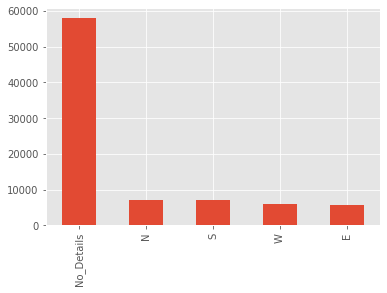

In [8]:
# now plot the data
import matplotlib.pyplot as plt
plt.style.use('ggplot')
accidents_by_direction.plot(kind='bar')

In [9]:
# do a time series analysis of the data
import datetime as dt
from suntime import Sun, SunTimeException

In [10]:
# filter out the data that is not on highways
accidents_data = accidents_data[accidents_data['highway_direction'] != 'No_Details']

In [11]:
def calculate_sunrise_sunset(latitude, longitude, date):
    # Calculate the sunrise and sunset times for the given date
    sun = Sun(latitude, longitude)
    try:
        return sun.get_local_sunrise_time(date), sun.get_local_sunset_time(date)
    except SunTimeException:
        # Return None if the sun does not rise or set on the given date
        return None, None

In [12]:
# seprate the date and time from the start time column
accidents_data["date"] = pd.to_datetime(accidents_data["Start_Time"]).dt.date
accidents_data["time"] = pd.to_datetime(accidents_data["Start_Time"]).dt.time

In [13]:
# get the sunrise and sunset times
accidents_data["sunrise"], accidents_data["sunset"] = zip(*accidents_data.apply(lambda x: calculate_sunrise_sunset(x["Start_Lattitude"], x["Start_Longitude"], x["date"]), axis=1))

In [14]:
def segment_sunrise(row):
    # Convert Start_Time and sunrise to datetime if it's not already
    row["Start_Time"] = pd.to_datetime(row["Start_Time"]).tz_localize(None)
    row["sunrise"] = row["sunrise"].tz_localize(None)

    # Define the start and end times for the segments
    start_time = row["sunrise"] - dt.timedelta(hours=2)
    end_time = row["sunrise"] + dt.timedelta(hours=2)

    # get time difference in hours
    time_diff_hours = (row["Start_Time"] - row["sunrise"]).total_seconds() / 3600

    # Define the segments
    segments = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

    # label the segments with -2, -1:45, -1:30, -1:15, -1, -0:45, -0:30, -0:15, 0, 0:15, 0:30, 0:45, 1, 1:15, 1:30, 1:45, 2, if the time of the accident is within the segment, otherwise leave it as empty string
    for i in segments:
        if time_diff_hours >= i and time_diff_hours < i + 0.25:
            return i

    return np.nan

# apply the function to the dataframe
accidents_data["sunrise_segment"] = accidents_data.apply(segment_sunrise, axis=1)
# count the number of accidents in each segment
accidents_by_sunrise_segment = accidents_data["sunrise_segment"].value_counts()
accidents_by_sunrise_segment

 2.00    473
 1.50    456
 1.25    414
 1.75    395
 0.75    374
 1.00    356
 0.50    322
 0.25    294
 0.00    283
-0.25    153
-0.50    124
-0.75    118
-2.00     89
-1.00     86
-1.25     84
-1.75     84
-1.50     81
Name: sunrise_segment, dtype: int64

In [15]:
# do the same for sunset
def segment_sunset(row):
    # Convert Start_Time and sunset to datetime if it's not already
    row["Start_Time"] = pd.to_datetime(row["Start_Time"]).tz_localize(None)
    row["sunset"] = row["sunset"].tz_localize(None)

    # Define the start and end times for the segments
    start_time = row["sunset"] - dt.timedelta(hours=2.25)
    end_time = row["sunset"] + dt.timedelta(hours=2.25)

    # get time difference in hours
    time_diff_hours = (row["Start_Time"] - row["sunset"]).total_seconds() / 3600

    # Define the segments
    segments = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25]

    # label the segments with -2, -1:45, -1:30, -1:15, -1, -0:45, -0:30, -0:15, 0, 0:15, 0:30, 0:45, 1, 1:15, 1:30, 1:45, 2, if the time of the accident is within the segment, otherwise leave it as empty string
    for i in segments:
        if time_diff_hours >= i and time_diff_hours < i + 0.25:
            return i

    return np.nan

# apply the function to the dataframe
accidents_data["sunset_segment"] = accidents_data.apply(segment_sunset, axis=1)
# count the number of accidents in each segment
accidents_by_sunset_segment = accidents_data["sunset_segment"].value_counts()
# sort by index starting from -2 to 2
accidents_by_sunset_segment.sort_index(inplace=True)
accidents_by_sunset_segment

-2.00    367
-1.75    364
-1.50    365
-1.25    357
-1.00    364
-0.75    342
-0.50    345
-0.25    327
 0.00    345
 0.25    290
 0.50    279
 0.75    232
 1.00    204
 1.25    204
 1.50    209
 1.75    161
 2.00    147
 2.25    136
Name: sunset_segment, dtype: int64

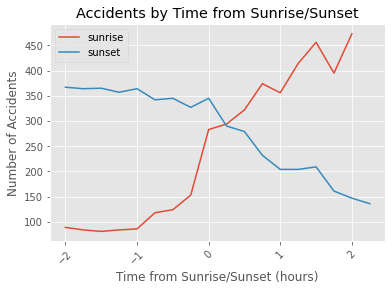

In [16]:
# now let's visualize the data by plotting the number of accidents in each segment
# create a line plot with X axis as the time segment and Y axis as the number of accidents for both sunrise and sunset
import matplotlib.pyplot as plt

# Group the data by sunrise segment and count the number of accidents in each segment
sunrise_counts = accidents_data['sunrise_segment'].value_counts().sort_index()

# Group the data by sunset segment and count the number of accidents in each segment
sunset_counts = accidents_data['sunset_segment'].value_counts().sort_index()

# sort the index so that the sunrise and sunset segments are in order from earliest to latest
sunrise_counts = sunrise_counts.sort_index()
sunset_counts = sunset_counts.sort_index()

# create a line plot with X axis as the time segment and Y axis as the number of accidents for both sunrise and sunset
plt.plot(sunrise_counts.index, sunrise_counts.values, label='sunrise')
plt.plot(sunset_counts.index, sunset_counts.values, label='sunset')

# add a legend
plt.legend()

# add labels and title
plt.xlabel('Time from Sunrise/Sunset (hours)')
plt.ylabel('Number of Accidents')

# add a title
plt.title('Accidents by Time from Sunrise/Sunset')

# rotate the x axis labels
plt.xticks(rotation=45)

# show the plot
plt.show()




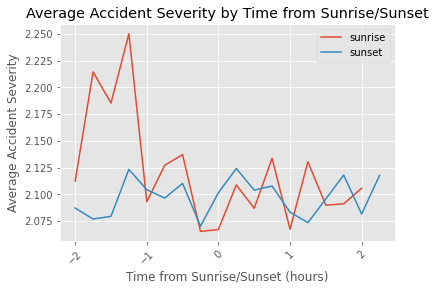

In [17]:
# Do the same but only focous on average accident severity
# Filter the data for sunrise period
sunrise_data = accidents_data[accidents_data['sunrise_segment'].notnull()]

# Group the data by sunrise segment and calculate the average accident severity in each segment
sunrise_avg_severity = sunrise_data.groupby('sunrise_segment')['Severity'].mean()

# Filter the data for sunset period
sunset_data = accidents_data[accidents_data['sunset_segment'].notnull()]

# Group the data by sunset segment and calculate the average accident severity in each segment
sunset_avg_severity = sunset_data.groupby('sunset_segment')['Severity'].mean()

# Plot the average accident severity for both sunrise and sunset
plt.plot(sunrise_avg_severity.index, sunrise_avg_severity.values, label='sunrise')
plt.plot(sunset_avg_severity.index, sunset_avg_severity.values, label='sunset')

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Time from Sunrise/Sunset (hours)')
plt.ylabel('Average Accident Severity')
plt.title('Average Accident Severity by Time from Sunrise/Sunset')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


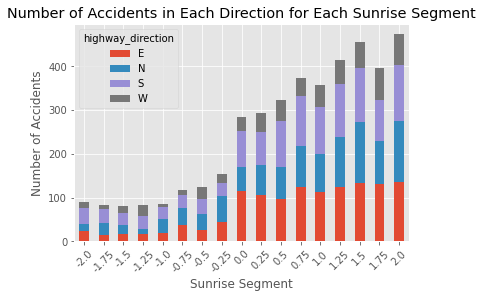

In [18]:
# Now focous only on Sunrise period, and plot the number of accidents in each direction for each segment
# Filter the data for sunrise period
sunrise_data = accidents_data[accidents_data['sunrise_segment'].notnull()]

# Group the data by sunrise segment and direction, and count the number of accidents in each segment-direction combination
sunrise_counts_by_direction = sunrise_data.groupby(['sunrise_segment', 'highway_direction']).size().unstack()

# Plot the number of accidents in each direction for each segment
sunrise_counts_by_direction.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Sunrise Segment')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents in Each Direction for Each Sunrise Segment')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


<AxesSubplot:xlabel='sunrise_segment'>

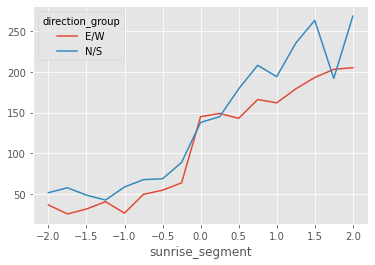

In [19]:
# Create a new column that groups the directions
accidents_data['direction_group'] = accidents_data['highway_direction'].map({'N': 'N/S', 'S': 'N/S', 'E': 'E/W', 'W': 'E/W'})

# Group by the new column and the sunrise_segment column, and count the number of accidents in each group
accidents_by_direction_and_sunrise_segment = accidents_data.groupby(['direction_group', 'sunrise_segment']).size()

# Reset the index of the DataFrame so that direction_group and sunrise_segment become columns
accidents_by_direction_and_sunrise_segment = accidents_by_direction_and_sunrise_segment.reset_index(name='accident_count')

# Pivot the DataFrame so that each direction group has its own column
accidents_by_direction_and_sunrise_segment = accidents_by_direction_and_sunrise_segment.pivot(index='sunrise_segment', columns='direction_group', values='accident_count')

# Plot the results
accidents_by_direction_and_sunrise_segment.plot(kind='line')

<AxesSubplot:xlabel='sunset_segment'>

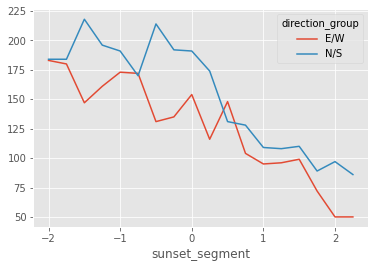

In [20]:
# do the same for sunset
# Group by the new column and the sunrise_segment column, and count the number of accidents in each group
accidents_by_direction_and_sunset_segment = accidents_data.groupby(['direction_group', 'sunset_segment']).size()
accidents_by_direction_and_sunset_segment = accidents_by_direction_and_sunset_segment.reset_index(name='accident_count')
accidents_by_direction_and_sunset_segment = accidents_by_direction_and_sunset_segment.pivot(index='sunset_segment', columns='direction_group', values='accident_count')
accidents_by_direction_and_sunset_segment.plot(kind='line')